In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [3]:
class InceptionBlock(nn.Module):
    def __init__(
        self,
        in_channels,
        out_1x1,
        out_3x3_reduced,
        out_3x3,
        out_5x5_reduced,
        out_5x5,
        out_pool,
    ):
        super().__init__()

        self.branch_1x1 = ConvBlock(in_channels, out_1x1, kernel_size=1, stride=1)

        self.branch_3x3 = nn.Sequential(
            ConvBlock(in_channels, out_3x3_reduced, kernel_size=1),
            ConvBlock(out_3x3_reduced, out_3x3, kernel_size=3, padding=1),
        )

        self.branch_5x5 = nn.Sequential(
            ConvBlock(in_channels, out_5x5_reduced, kernel_size=1),
            ConvBlock(out_5x5_reduced, out_5x5, kernel_size=3, padding=1),
            ConvBlock(out_5x5, out_5x5, kernel_size=3, padding=1),
        )

        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            ConvBlock(in_channels, out_pool, kernel_size=1),
        )

    def forward(self, x):
        y1 = self.branch_1x1(x)
        y2 = self.branch_3x3(x)
        y3 = self.branch_5x5(x)
        y4 = self.branch_pool(x)

        return torch.cat([y1, y2, y3, y4], 1)

In [4]:
class GoogLeNet(nn.Module):
    def __init__(self, img_channels):
        super().__init__()

        self.first_conv_block = nn.Sequential(
            ConvBlock(img_channels, 192, kernel_size=3, padding=1)
        )

        self.inception_3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception_3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)

        self.maxpool_1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception_4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception_4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception_4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception_4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)

        self.maxpool_2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception_5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception_5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        self.avgpool = nn.AvgPool2d(kernel_size=8, stride=1)
        self.fc = nn.Linear(1024, 10)

    def forward(self, x):
        out = self.first_conv_block(x)

        out = self.inception_3a(out)
        out = self.inception_3b(out)
        out = self.maxpool_1(out)

        out = self.inception_4a(out)
        out = self.inception_4b(out)
        out = self.inception_4c(out)
        out = self.inception_4d(out)
        out = self.inception_4e(out)
        out = self.maxpool_2(out)

        out = self.inception_5a(out)
        out = self.inception_5b(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)

        return out

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [7]:
transform = transforms.Compose(
    [
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

In [8]:
train_dataset = torchvision.datasets.MNIST(
    root="./data", train=True, transform=transform, download=True
)
test_dataset = torchvision.datasets.MNIST(
    root="./data", train=False, transform=transform, download=True
)

0.7%

100.0%


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%
6.0%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100.0%


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100.0%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [9]:
batch_size = 64
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(
    train_dataset, [train_size, val_size]
)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset, batch_size=batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=False
)

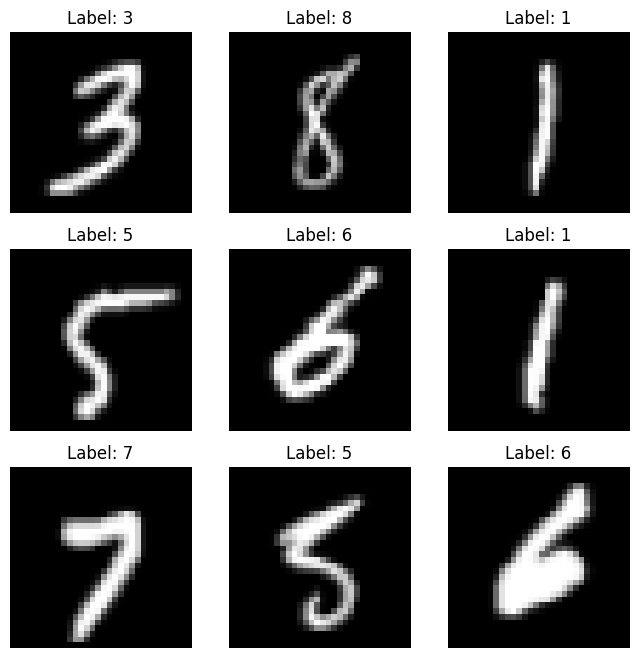

In [10]:
def plot_samples(loader):
    dataiter = iter(loader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    for i in range(9):
        image = images[i].numpy().squeeze()
        label = labels[i].item()
        axes[i].imshow(image, cmap="gray")
        axes[i].set_title(f"Label: {label}")
        axes[i].axis("off")


plt.show()

plot_samples(train_loader)

In [11]:
model = GoogLeNet(1).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
NUM_EPOCHS = 32

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    total_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = outputs.max(1)
        total_train += labels.size(0)
        correct_train += predicted.eq(labels).sum().item()

    train_accuracy = 100 * correct_train / total_train
    average_train_loss = total_train_loss / len(train_loader)
    train_losses.append(loss.item())
    model.eval()
    total_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            total_val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_accuracy = 100 * correct_val / total_val
    average_val_loss = total_val_loss / len(val_loader)
    val_losses.append(loss.item())
    print(
        f"Epoch [{epoch + 1}/{NUM_EPOCHS}], "
        f"Train Accuracy: {train_accuracy:.2f}%, Train Loss: {average_train_loss:.4f}, "
        f"Validation Accuracy: {val_accuracy:.2f}%, Validation Loss: {average_val_loss:.4f}"
    )

Epoch [1/32], Train Accuracy: 96.64%, Train Loss: 0.1122, Validation Accuracy: 95.88%, Validation Loss: 0.1325
Epoch [2/32], Train Accuracy: 98.44%, Train Loss: 0.0485, Validation Accuracy: 98.25%, Validation Loss: 0.0554
Epoch [3/32], Train Accuracy: 98.84%, Train Loss: 0.0378, Validation Accuracy: 98.88%, Validation Loss: 0.0359
Epoch [4/32], Train Accuracy: 98.97%, Train Loss: 0.0328, Validation Accuracy: 98.22%, Validation Loss: 0.0545
Epoch [5/32], Train Accuracy: 99.05%, Train Loss: 0.0303, Validation Accuracy: 98.90%, Validation Loss: 0.0381
Epoch [6/32], Train Accuracy: 99.13%, Train Loss: 0.0289, Validation Accuracy: 99.23%, Validation Loss: 0.0282
Epoch [7/32], Train Accuracy: 99.22%, Train Loss: 0.0249, Validation Accuracy: 99.21%, Validation Loss: 0.0252
Epoch [8/32], Train Accuracy: 99.30%, Train Loss: 0.0223, Validation Accuracy: 99.40%, Validation Loss: 0.0216
Epoch [9/32], Train Accuracy: 99.33%, Train Loss: 0.0208, Validation Accuracy: 98.83%, Validation Loss: 0.0468
E

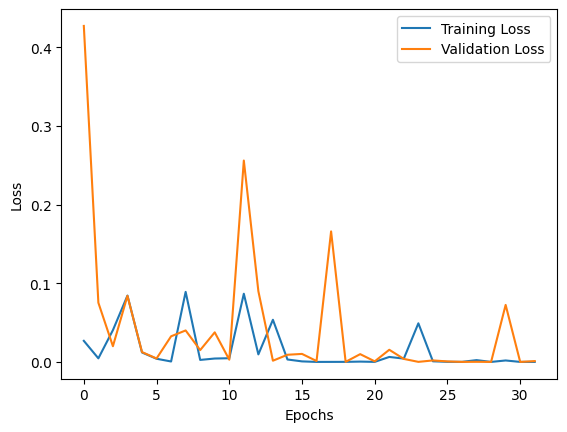

In [13]:
plt.plot(range(NUM_EPOCHS), train_losses, label="Training Loss")
plt.plot(range(NUM_EPOCHS), val_losses, label="Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

In [14]:
import torch
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix,
)

model.eval()

all_predictions = []
all_labels = []

with torch.inference_mode():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)

        _, predictions = torch.max(outputs, 1)

        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_predictions = np.array(all_predictions)
all_labels = np.array(all_labels)

accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average="weighted")
precision = precision_score(all_labels, all_predictions, average="weighted")
recall = recall_score(all_labels, all_predictions, average="weighted")

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

print("Classification Report:")
print(classification_report(all_labels, all_predictions))

conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9920
F1 Score: 0.9920
Precision: 0.9921
Recall: 0.9920
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       980
           1       0.99      1.00      0.99      1135
           2       1.00      0.99      0.99      1032
           3       1.00      1.00      1.00      1010
           4       1.00      0.97      0.99       982
           5       0.99      1.00      0.99       892
           6       0.99      0.99      0.99       958
           7       0.98      1.00      0.99      1028
           8       1.00      0.99      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

Confusion Matrix:
[[ 976    0    0    0    0    2    1    1    0    0]
 [   2 1131    0    1    0    0    0    1    0    0]
 [   0    2 1022    0    0 

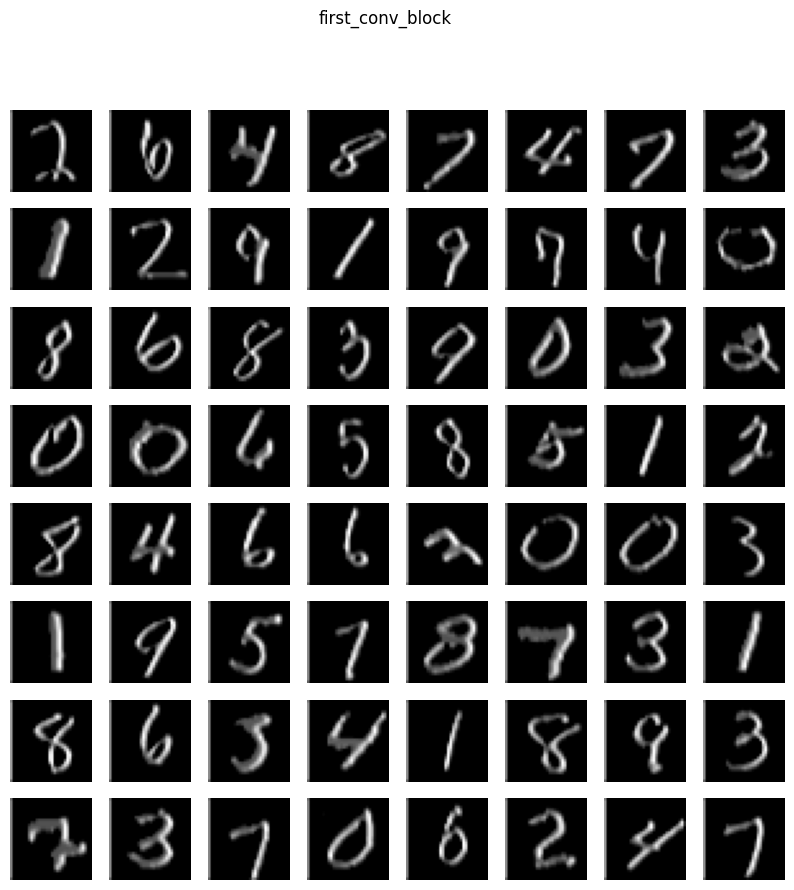

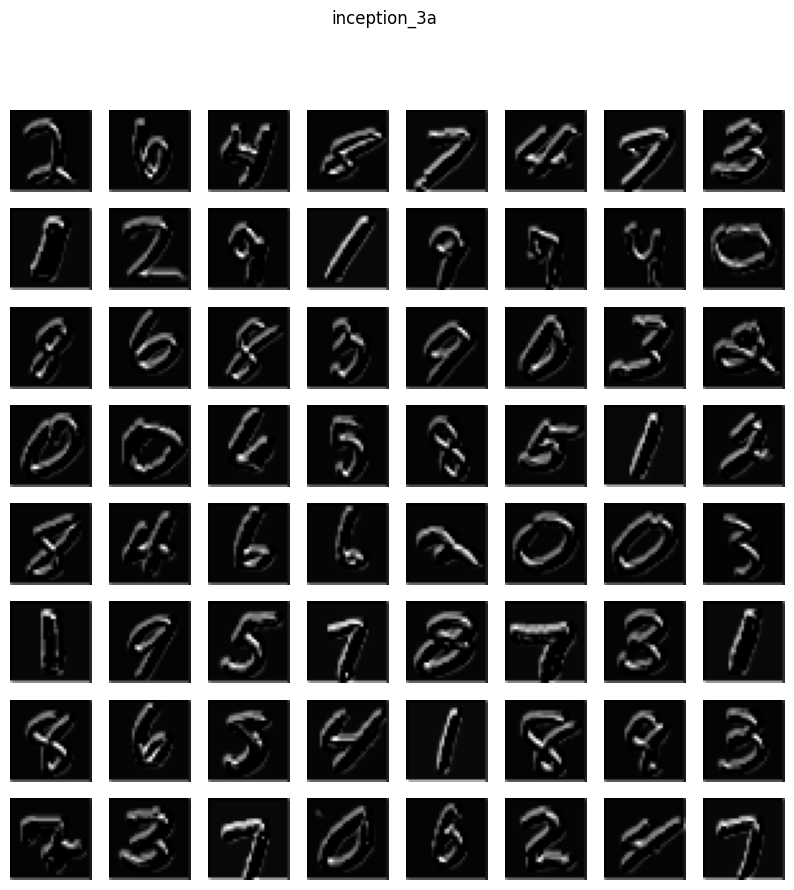

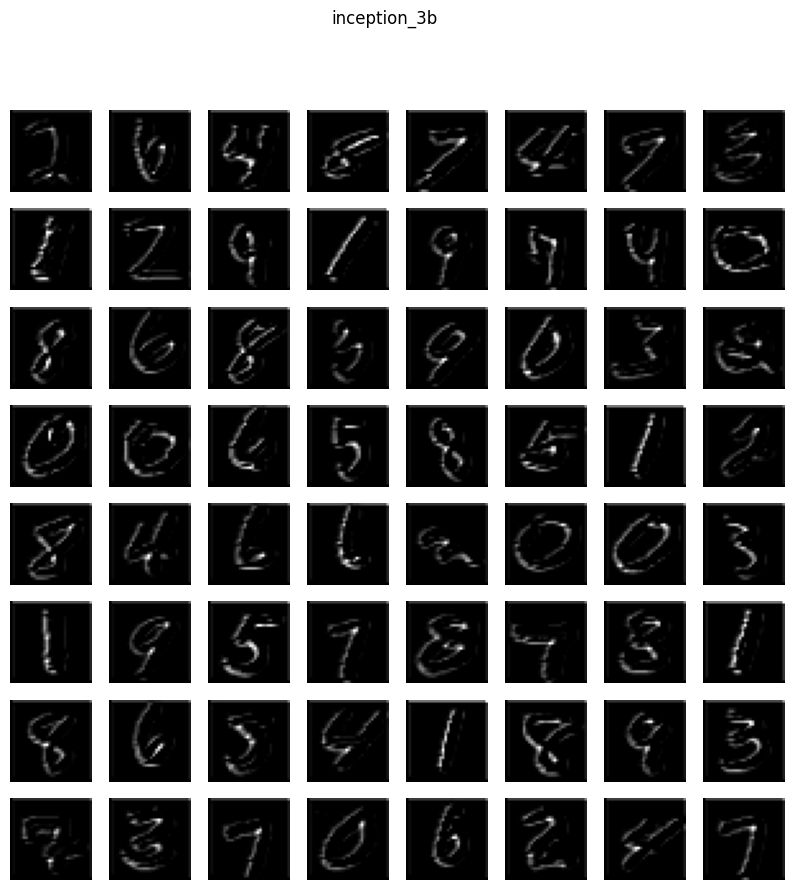

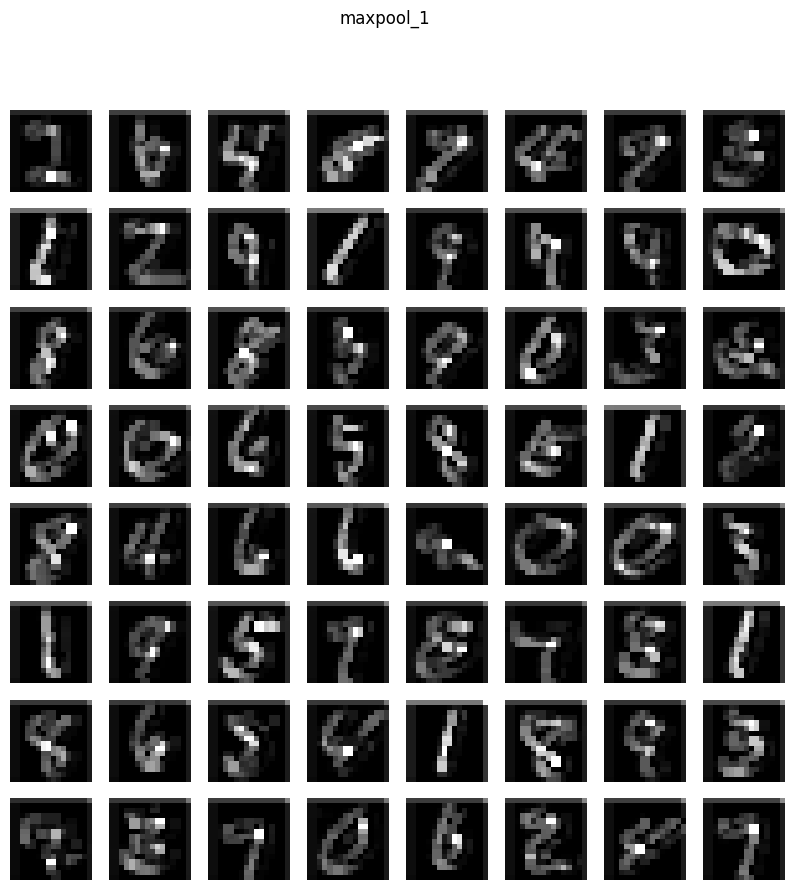

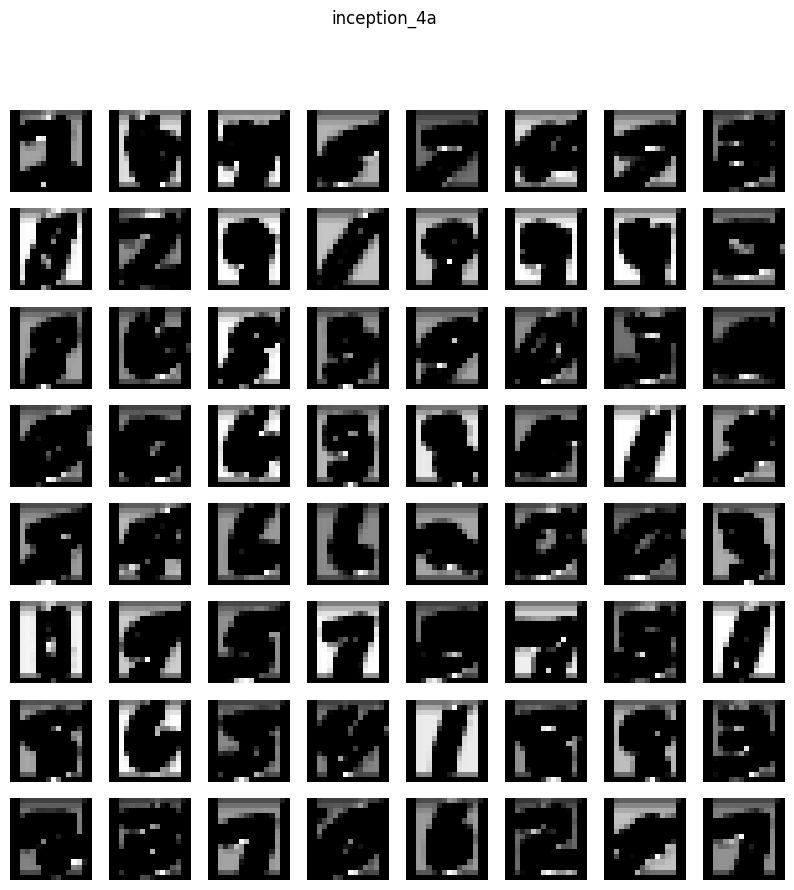

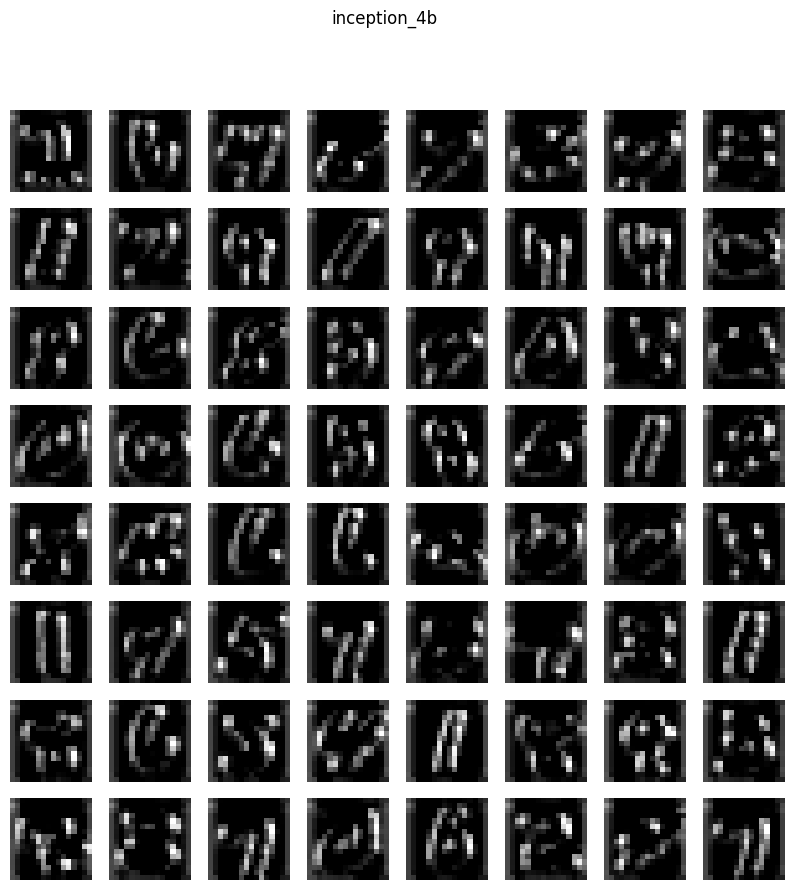

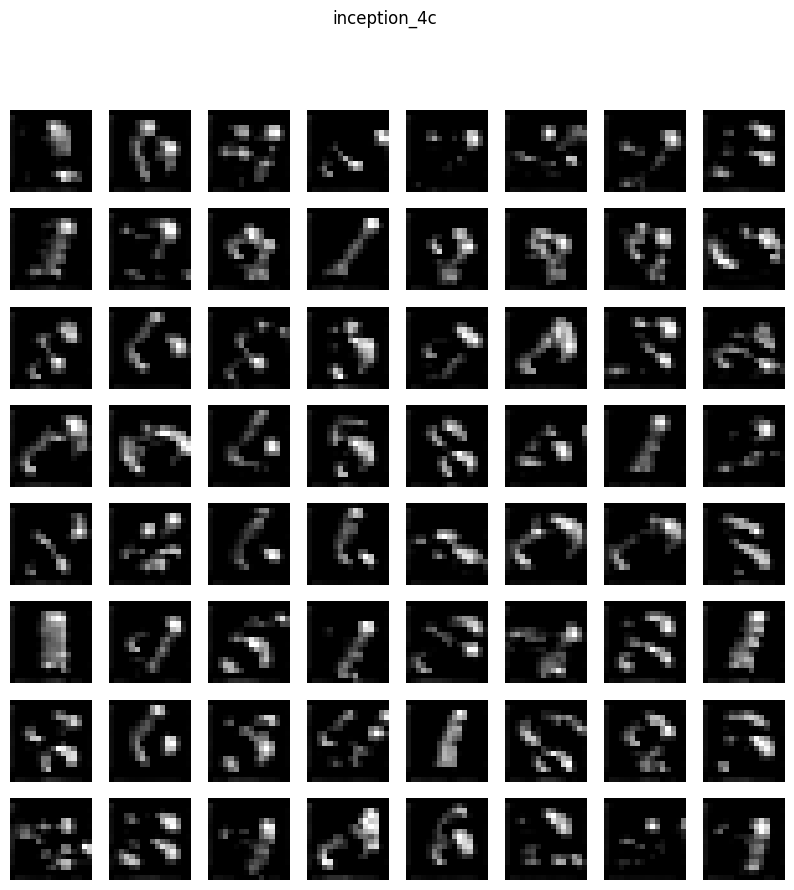

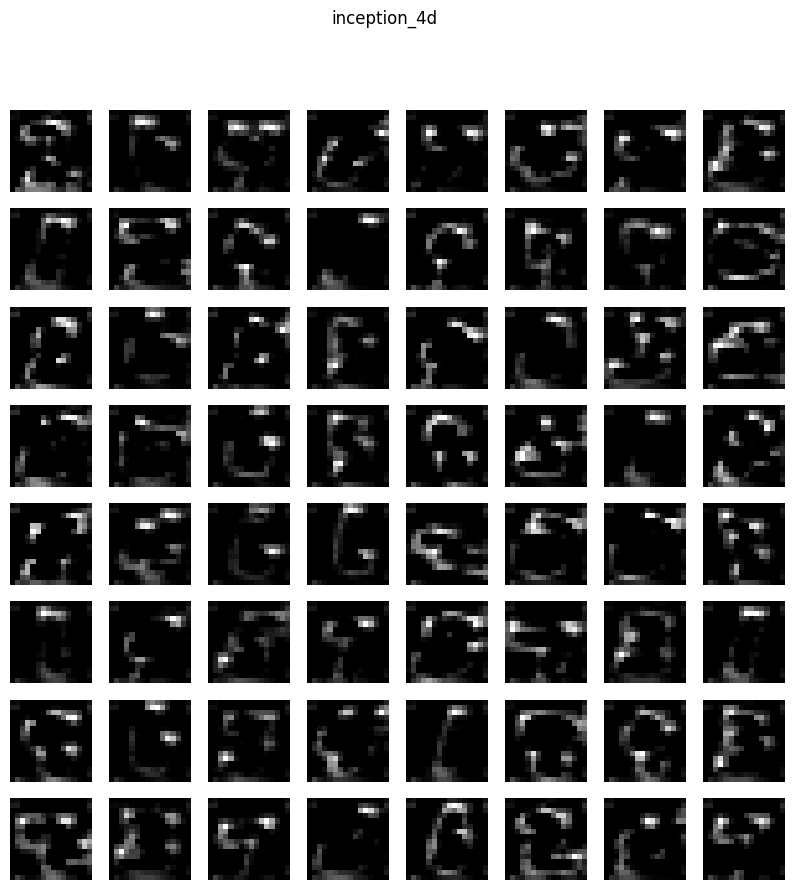

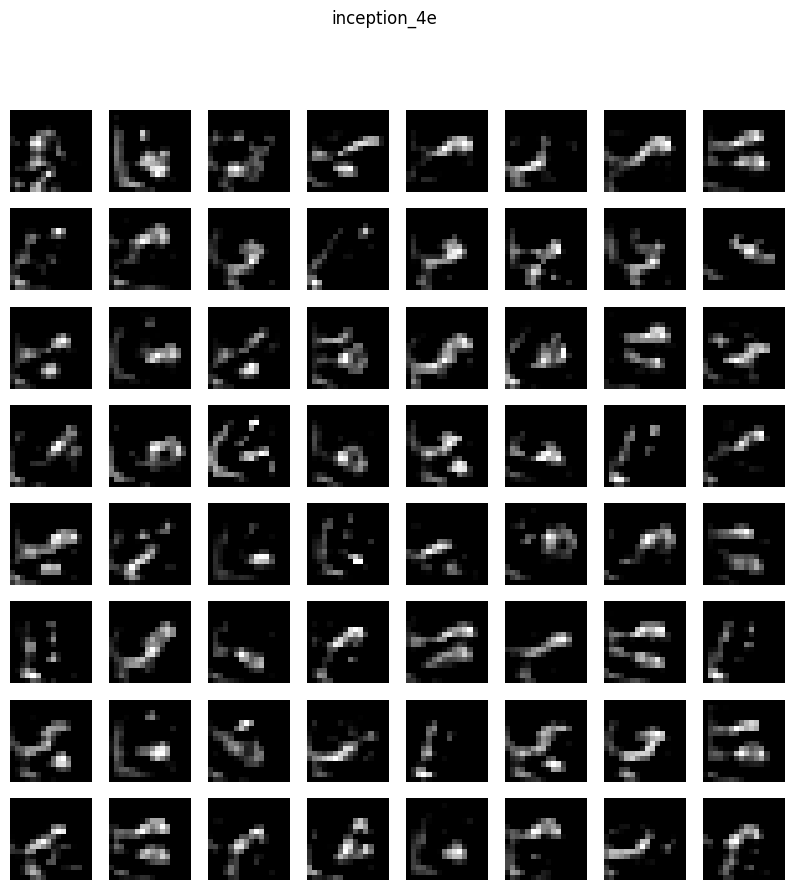

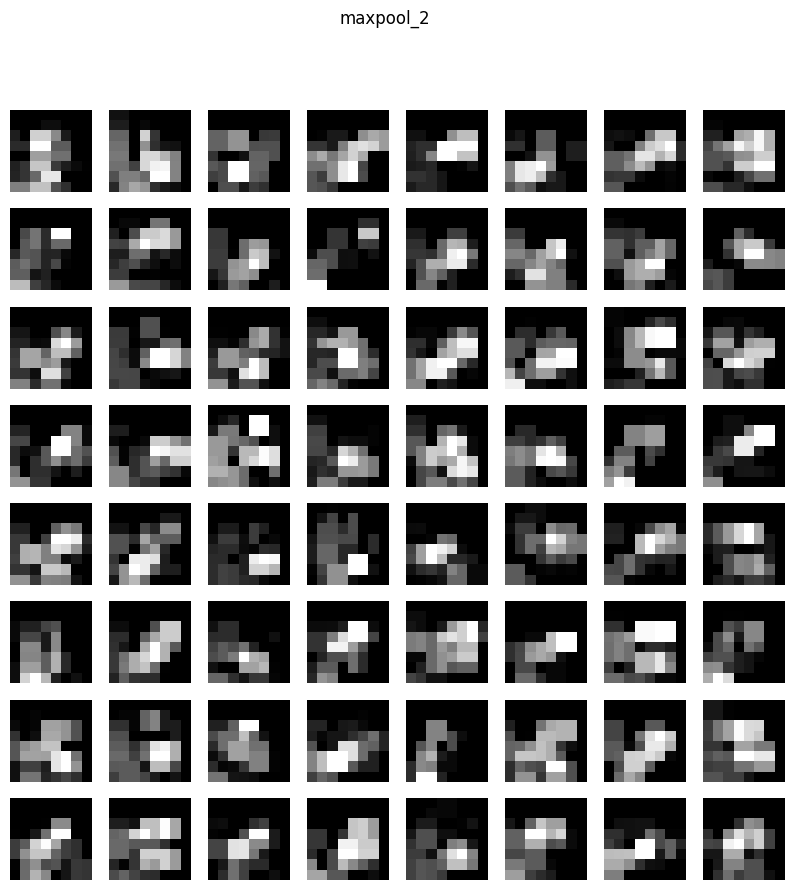

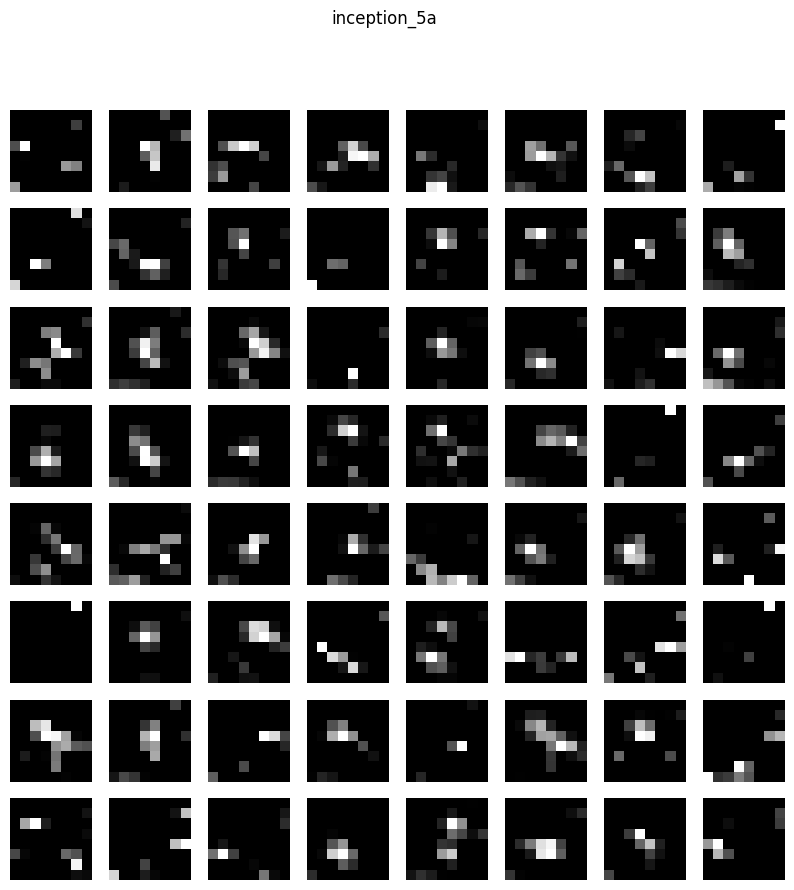

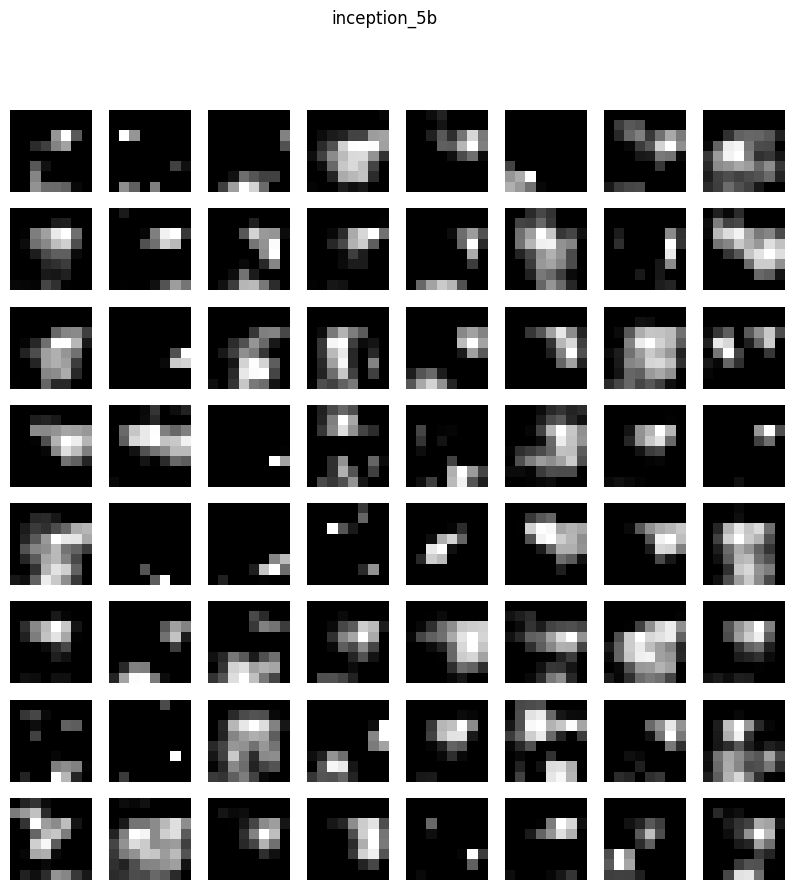

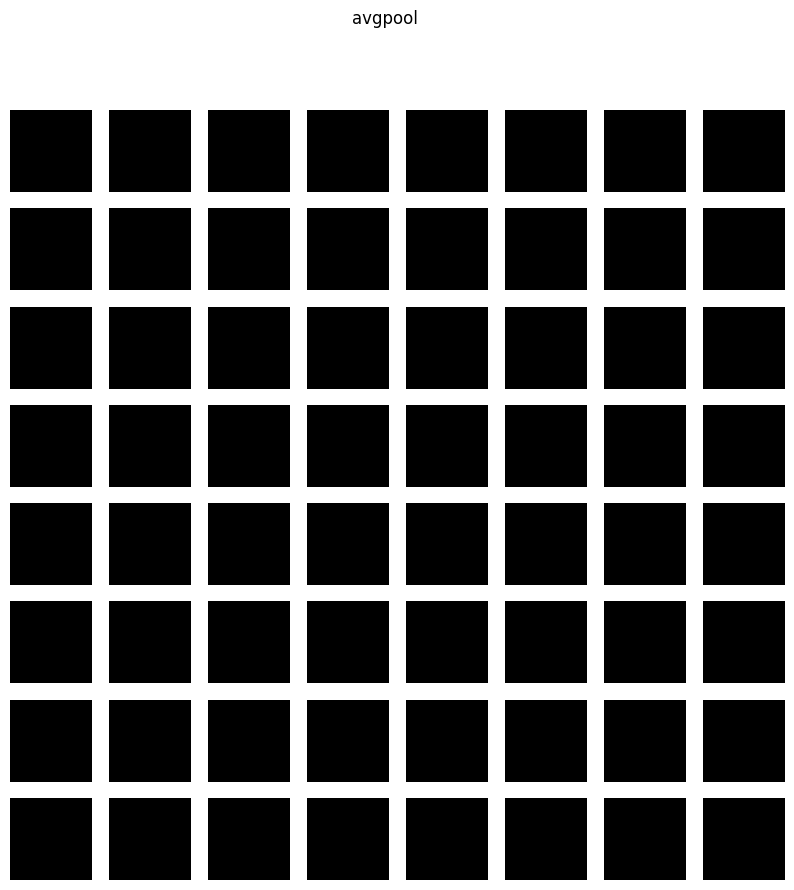

In [28]:
import matplotlib.pyplot as plt
import numpy as np


def plot_images_grid(images, layer_name):
    batch_size, channels, height, width = images.size()

    grid_size = int(np.ceil(np.sqrt(batch_size)))
    fig, axs = plt.subplots(grid_size, grid_size, figsize=(10, 10))

    for i in range(batch_size):
        ax = axs[i // grid_size, i % grid_size]
        ax.imshow(images[i, 0].cpu().numpy(), cmap="gray")
        ax.axis("off")

    plt.suptitle(layer_name)
    plt.show()


data_iter = iter(train_loader)
example_data, _ = next(data_iter)
example_data = example_data.to("cuda")

layer_names = [
    "first_conv_block",
    "inception_3a",
    "inception_3b",
    "maxpool_1",
    "inception_4a",
    "inception_4b",
    "inception_4c",
    "inception_4d",
    "inception_4e",
    "maxpool_2",
    "inception_5a",
    "inception_5b",
    "avgpool",
]

with torch.no_grad():
    for i, layer_name in enumerate(layer_names):
        layer = getattr(model, layer_name)

        example_data = layer(example_data)
        plot_images_grid(example_data.cpu(), layer_name)